In [4]:
import numpy as np
import numpy.linalg as lin

import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt

from matrix_functions import diagonal_fa, lanczos_fa_multi_k, krylov_subspace

In [5]:
dim = 100
rng = np.random.default_rng(42)
a_diag = np.array(list(range(1, dim+1)))
A = np.diag(a_diag)
lambda_min = min(a_diag)
lambda_max = max(a_diag)
kappa = np.abs(lambda_max) / np.abs(lambda_min)
f = lambda x: 1/(x**2)  # or np.power(x, -2.) or something? f(x) = 1/x^2

In [6]:
x = rng.standard_normal(dim)
ground_truth = diagonal_fa(f, a_diag, x)
krylov_basis = krylov_subspace(A, x)

In [7]:
ks = list(range(1, dim+1))
lanczos_errors = []
krylov_errors = []
our_bound = []
for k, lanczos_estimate in zip(ks, lanczos_fa_multi_k(f, A, x, ks=ks)):
    lanczos_errors.append(lin.norm(lanczos_estimate - ground_truth))

    coeffs, _, _, _ = lin.lstsq(krylov_basis[:, :k], ground_truth, rcond=None)
    krylov_error = lin.norm(krylov_basis[:, :k] @ coeffs - ground_truth)
    krylov_errors.append(krylov_error)
    our_bound.append((kappa ** k) * krylov_error)

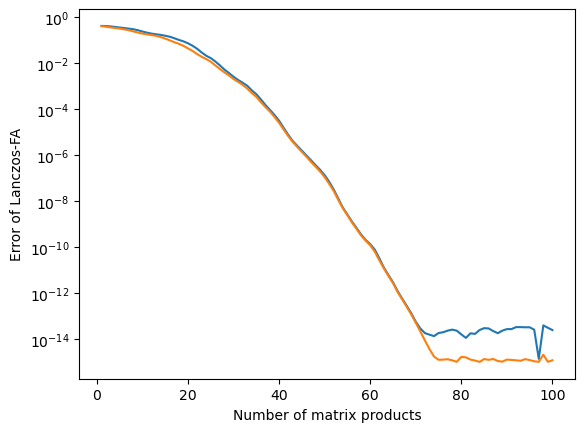

In [8]:
results = pd.DataFrame({
    "Number of matrix products": ks,
    "Error of Lanczos-FA": lanczos_errors,
    "Error of Krylov subspace": krylov_errors,
    "Our bound": our_bound
})
sns.lineplot(x="Number of matrix products", y="Error of Lanczos-FA", data=results)
sns.lineplot(x="Number of matrix products", y="Error of Krylov subspace", data=results)
# sns.lineplot(x="Number of matrix products", y="Our bound", data=results)
plt.yscale('log')